In [1]:
import pyvisa as visa
from pyvisa.constants import Parity
import numpy as np
import matplotlib.pyplot as plt
from struct import unpack, pack
import datetime as dt
import time
from threading import Timer
from scipy.optimize import curve_fit
import InstrumentControl as ic
%matplotlib inline

# Initialize equipment

In [2]:
osci = ic.osc('TCPIP0::196.168.0.100::inst0::INSTR')
bnc = ic.pulsegen('ASRL6::INSTR')
#lock = ic.lockin('ASRL4::INSTR')
mag = ic.magnet('ASRL3::INSTR')
keith = ic.keithley('ASRL5::INSTR')
ls = ic.LakeShore10T('ASRL1::INSTR')
awg = ic.awg('USB0::0x0957::0x2807::MY59000287::INSTR')
#agilent = ic.AgilentE3640('ASRL7::INSTR')
time.sleep(1)
osci.whoami();bnc.whoami();keith.whoami();awg.whoami();#agilent.whoami()
#lock.whoami()
mag.getfieldsetpoint();ls.readsampleT(); print(ls.T)

initialized
initialized
initialized
initialized
initialized
initialized
TEKTRONIX,MDO3024,C034284,CF:91.1CT FV:v1.24

BNC,577-4,36239,1.1.5-2.0.2.7

KEITHLEY INSTRUMENTS INC.,MODEL 2000,4307272,B01  /A02  

Agilent Technologies,33512B,MY59000287,5.02-3.15-2.00-58-00
OK:0.000000@get field setpoint
1.9145


# General BNC pulsing

In [5]:
pulsewidth = 0.0003
pol = 'norm'
period = 0.0006
bnc.setperiod(period)
for i in [1,2,3]:
    bnc.setchannel(i)
    bnc.setmux(i)
    bnc.write(':puls2:cmod norm')
    bnc.write(':puls2:wco 0')
    bnc.setpolarity(pol)
    bnc.setpulse(pulsewidth)
    bnc.setamp(5.0)
    bnc.runchannel()

In [ ]:
mag.setfield(4.0)

In [ ]:
ls.setT(2.4)

In [ ]:
ls.readsampleT();ls.readvtiT();
print(ls.T);print(ls.vtiT)

In [ ]:
bnc.run()
osci.triggermodenormal()

In [ ]:
bnc.stop()
osci.triggermodeauto()

# CW field sweeps at different T

In [3]:
s=1692
s

1692

In [ ]:
osci.SetHorizontalScale(0.1)

100.0000E-3



<IPython.core.display.Javascript object>


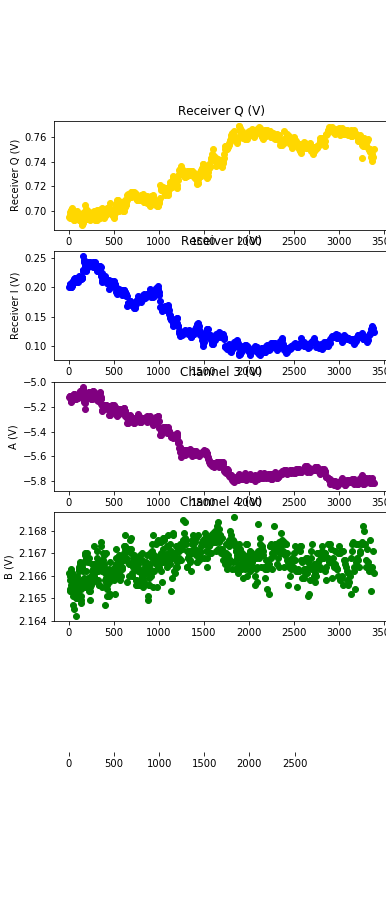

KeyboardInterrupt: 

In [4]:
%matplotlib notebook

horzscale = 0.1
waittime = 7200;
directory = 'C:/Users/esr/OneDrive - Johns Hopkins University/Data/'

osci.SetHorizontalScale(horzscale)
sampperiod = horzscale*10

ffile = 'EPR_Cr8_10202020/removehelium/s0'+str(s)+'_Hepump'
savefile = directory+ffile
ic.longscan(osci,keith,ls,sampperiod,waittime,savefile)

In [36]:
!mkdir CW_scans\fieldsweepvsT\m08\btwscans

100.0000E-3



<IPython.core.display.Javascript object>


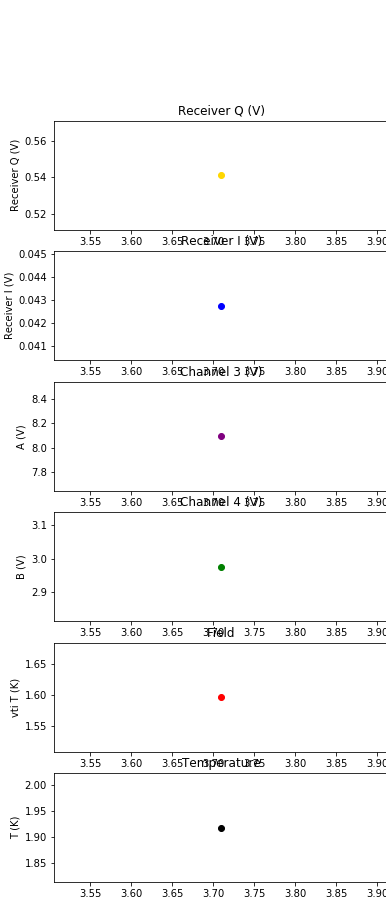

OK:0.000000@set field setpoint 8.000000


<IPython.core.display.Javascript object>


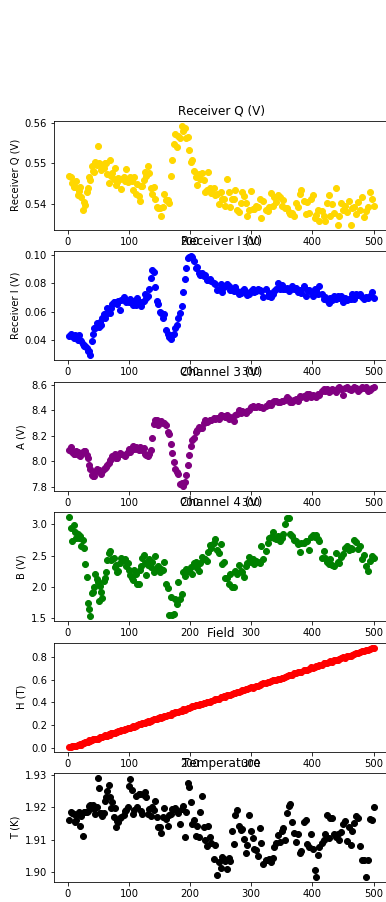

In [ ]:
%matplotlib notebook

ts = np.arange(2.0,6.4,0.4); 
ts = np.append([1.8],ts)
#ts = np.array([2.5,2.6])
tstr = np.array(np.append([0.0],ts),dtype='|S9');
#tstr = np.array(ts,dtype='|S9');
for i,tst in enumerate(tstr):
    for j in range(len(tst)):
        if tst[j]=='.':
            tst = tst[:j]+'p'+tst[j+1:]
            if j<2:
                tst = '0'+tst
            break
    if len(tst)<5:
        tst = tst+'0'
    tstr[i] = tst+'K'

wminutes=np.zeros(len(ts))+5;
wminutes[0] = 0.1;wminutes[1] = 30
H = [0,8]; flipper=1;

horzscale = 0.1
waittime = 60*wminutes;
directory = 'C:/Users/esr/OneDrive - Johns Hopkins University/Data/'

osci.SetHorizontalScale(horzscale)
sampperiod = horzscale*10

for i,t in enumerate(ts):
    ffile = 'EPR_Cr8_10202020/CW_scans/fieldsweepvsT/btwscans/s0'+str(s)+'_btw_'+tstr[i]
    savefile = directory+ffile
    ic.longscan(osci,keith,ls,sampperiod,waittime[i],savefile)
    
    mag.setfield(H[int(flipper)])
    ffile = 'EPR_Cr8_10202020/CW_scans/fieldsweepvsT/m08/s0'+str(s)+'_'+tstr[i]
    savefile = directory+ffile
    ic.longscanH(osci,keith,ls,H[int(flipper)],sampperiod,savefile)
    ls.setT(t)
    s=s+1
    flipper = np.logical_not(flipper)

# Set AWG to sinusoid

In [31]:
ch = 1; amplitude = 0.300; offset = 2.2; freq = 4000000;
awg.write('SOUR%i:FUNC SIN' %(ch))
awg.write('SOUR%i:VOLT %f' % (ch,amplitude))
awg.write('SOUR%i:VOLT:OFFS %f' % (ch,offset))
awg.write('SOUR%i:FREQ %f' % (ch,freq))
awg.turnoffmodulation(ch,'SUM')

# Saturation Recovery

__set up__

In [ ]:
ch = 1; amp = 0.3; offset=2.05; period = 40-np.pi/5; dcycle=50;
awg.setfuncpulse(ch,amp,offset,period,dcycle)
typ = 'SUM';freq=4000000;depth = 133.33;
awg.setmodulation(ch,typ,freq,depth)

In [ ]:
awg.turnoffmodulation(ch,'SUM')

In [16]:
awg.run(1)

In [14]:
awg.stop(1)

__long waveform, many pulses__

In [20]:
!mkdir SatRec\m07
!mkdir SatRec\m07\Trise
!mkdir SatRec\m07\btw
!mkdir SatRec\m07\ramps

In [6]:
s=1741
s

1741

In [ ]:
ts = np.arange(1.8,10.2,0.2); 
#ts = np.append([1.8],ts)
tstr = np.array(np.append([4.0],ts),dtype='|S9');
for i,tst in enumerate(tstr):
    for j in range(len(tst)):
        if tst[j]=='.':
            tst = tst[:j]+'p'+tst[j+1:]
            if j<2:
                tst = '0'+tst
            break
    if len(tst)<5:
        tst = tst+'0'
    tstr[i] = tst+'K'
tstr

In [ ]:
ls.setT(0.0)

In [ ]:
H = np.arange(4,5.225,0.025); onf = np.array(H,dtype='|S7')
for i,n in enumerate(onf):
    if len(n)<5:
        onf[i] = n+'00'
    onf[i] = '_'+onf[i][0]+'p'+onf[i][2:5]+'T'
    
onf

In [14]:
H = np.array([4.55]); onf = np.array(H,dtype='|S7')
for i,n in enumerate(onf):
    if len(n)<5:
        onf[i] = n+'00'
    onf[i] = '_'+onf[i][0]+'p'+onf[i][2:5]+'T'

In [15]:
onf

array(['_4p550T'], 
      dtype='|S7')

400.0000E-3



<IPython.core.display.Javascript object>


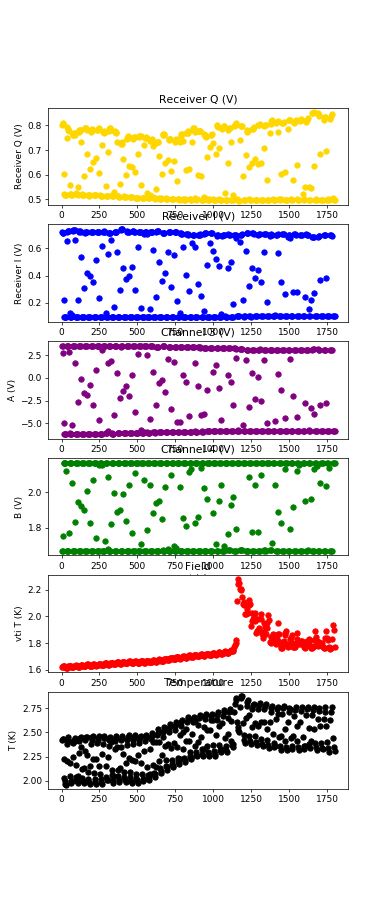

20.0000

400.0000E-3



<IPython.core.display.Javascript object>


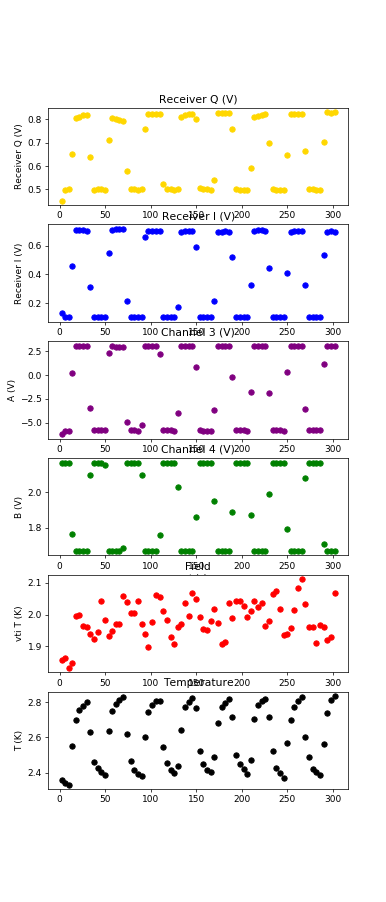

20.0000

400.0000E-3



<IPython.core.display.Javascript object>


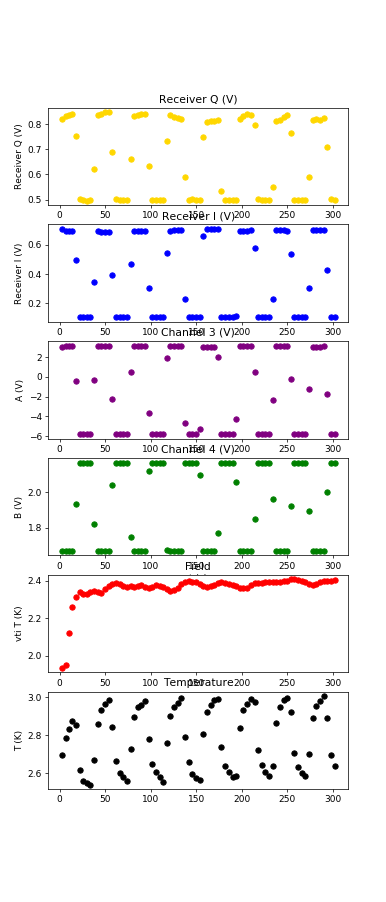

20.0000

400.0000E-3



<IPython.core.display.Javascript object>


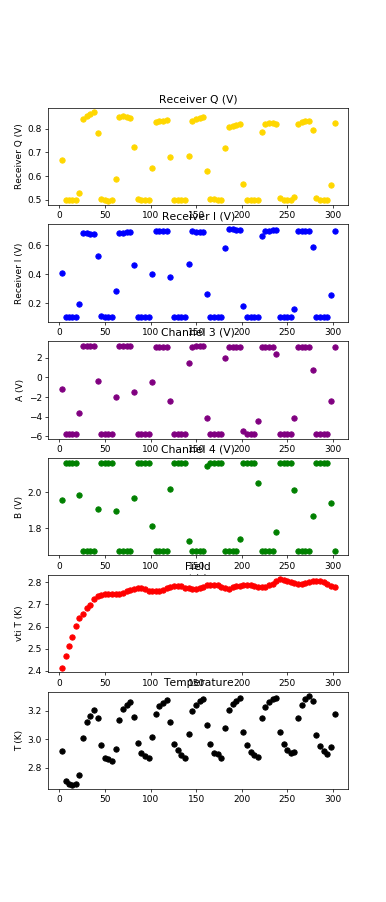

20.0000

400.0000E-3



<IPython.core.display.Javascript object>


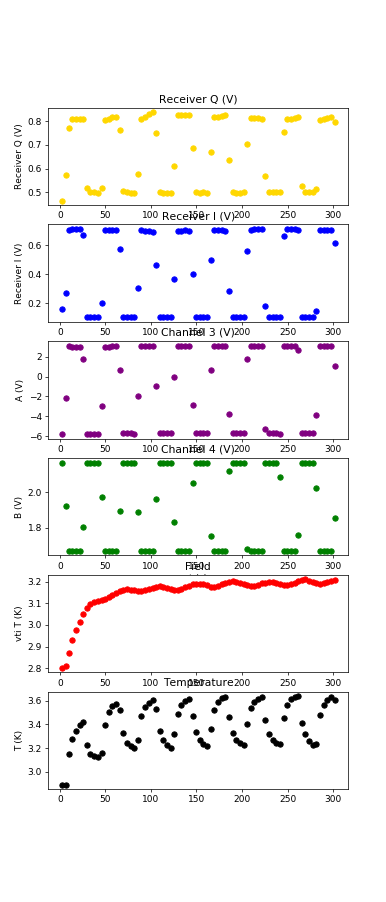

20.0000

400.0000E-3



<IPython.core.display.Javascript object>


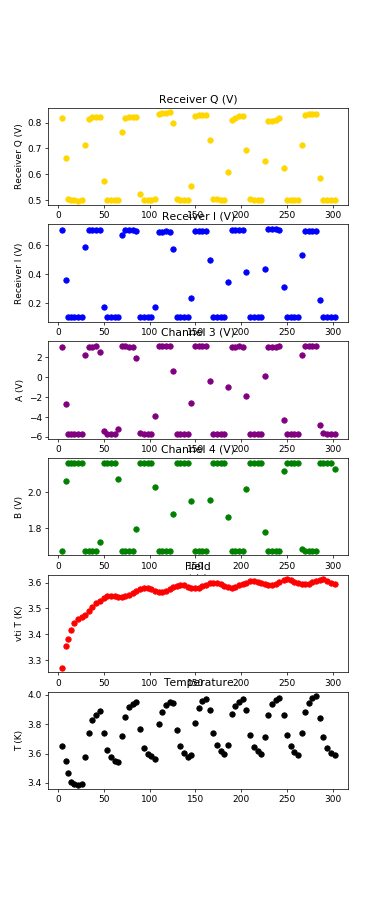

20.0000

400.0000E-3



<IPython.core.display.Javascript object>


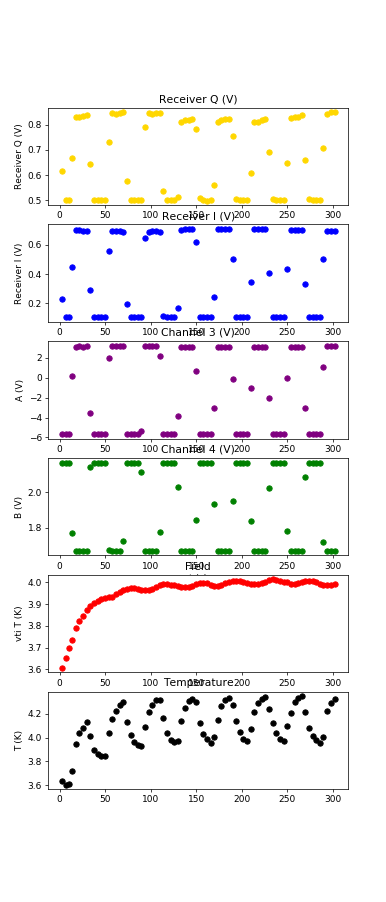

20.0000

400.0000E-3



<IPython.core.display.Javascript object>


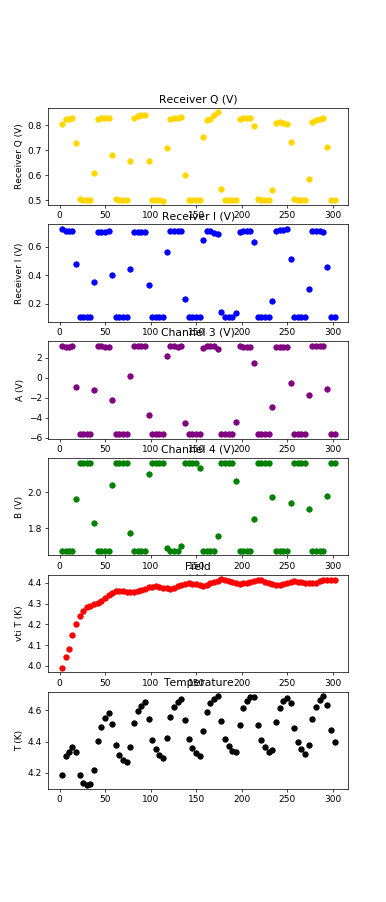

20.0000

400.0000E-3



<IPython.core.display.Javascript object>


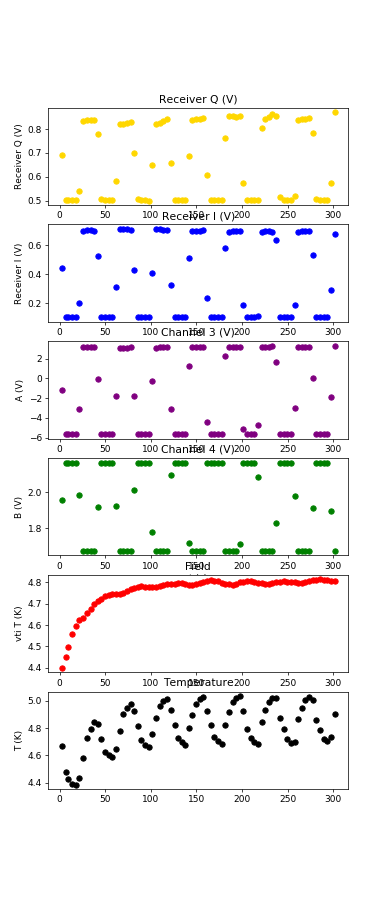

20.0000

400.0000E-3



<IPython.core.display.Javascript object>


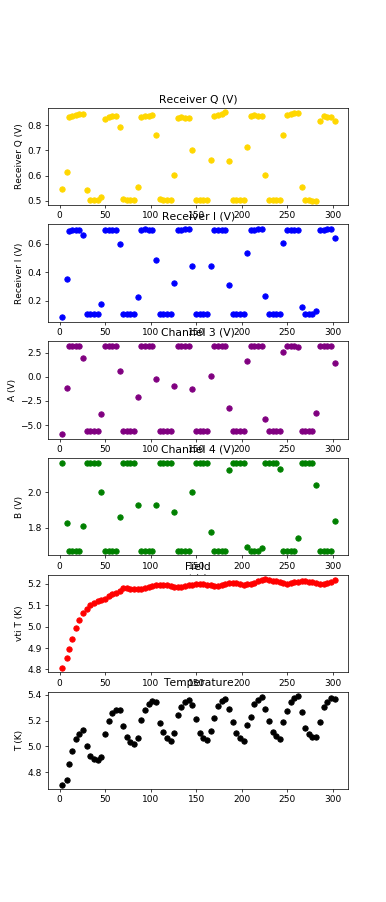

20.0000



In [29]:
%matplotlib notebook

#ts = np.arange(1.8,5.2,0.2); 
ts = np.arange(2.0,6.4,0.4); 
ts = np.append([1.8],ts)
#ts = np.array([2.5,2.6])
tstr = np.array(np.append([0.0],ts),dtype='|S9');
#tstr = np.array(ts,dtype='|S9');
for i,tst in enumerate(tstr):
    for j in range(len(tst)):
        if tst[j]=='.':
            tst = tst[:j]+'p'+tst[j+1:]
            if j<2:
                tst = '0'+tst
            break
    if len(tst)<5:
        tst = tst+'0'
    tstr[i] = tst+'K'

H = np.array([0.0]); onf = np.array(H,dtype='|S7')
for i,n in enumerate(onf):
    if len(n)<5:
        onf[i] = n+'00'
    onf[i] = '_'+onf[i][0]+'p'+onf[i][2:5]+'T'

wminutes=np.zeros(len(ts))+5;
wminutes[0] = 30;# wminutes[1] = 30
horzscale = 20
shorthorzscale = 0.4
ramprate = 0.16

shortsampperiod=shorthorzscale*10
Tsampperiod = 4
scantime = horzscale*10
waittime = 60*wminutes
directory = 'C:/Users/esr/OneDrive - Johns Hopkins University/Data/EPR_Cr8_10202020/SatRec/m07/'
k=0
for i,t in enumerate(ts):
    osci.SetHorizontalScale(shorthorzscale)
    ffile = 'btw/s0'+str(s)+'_btw_'
    savefile = directory+ffile
    ic.longscan(osci,keith,ls,shortsampperiod,waittime[i],savefile)
    
    osci.SetHorizontalScale(horzscale)
    ffile = 'Trise/s0'+str(s)+'_Trise'
    savefile = directory+ffile
    ic.longscanjustT(ls,Tsampperiod,scantime+20,savefile)
    osci.measureall(1)
    ffile = 's0'+str(s)+'_'+tstr[i]+onf[k]
    savefile=directory+ffile
    osci.savedata(savefile)
    s=s+1
    
   # tt = np.array([-0.18,-0.16,-0.14,-0.12,-0.10,-0.08,-0.06,-0.04,-0.02,0])+t
   # for ttt in tt:
   #     ls.setT(ttt);
   #     time.sleep(60)
    ls.setT(t)
        
    

In [ ]:
%matplotlib notebook

ts = np.arange(1.6,5.2,0.2); 
tstr = np.array(np.append([0.0],ts),dtype='|S9');
#tstr = np.array(ts,dtype='|S9');
for i,tst in enumerate(tstr):
    for j in range(len(tst)):
        if tst[j]=='.':
            tst = tst[:j]+'p'+tst[j+1:]
            if j<2:
                tst = '0'+tst
            break
    if len(tst)<5:
        tst = tst+'0'
    tstr[i] = tst+'K'

H = np.arange(4,5.225,0.025); onf = np.array(H,dtype='|S7')
for i,n in enumerate(onf):
    if len(n)<5:
        onf[i] = n+'00'
    onf[i] = '_'+onf[i][0]+'p'+onf[i][2:5]+'T'

wminutes=np.zeros(len(ts))+60;
#wminutes[0] = 60
horzscale = 20
shorthorzscale = 0.4
ramprate = 0.16

shortsampperiod=shorthorzscale*10
Tsampperiod = 4
scantime = horzscale*10
waittime = 60*wminutes
directory = 'C:/Users/esr/OneDrive - Johns Hopkins University/Data/EPR_Cr8_10202020/SatRec/m04/'

for i,t in enumerate(ts):
    osci.SetHorizontalScale(shorthorzscale)
    ffile = 'btw/s0'+str(s)+'_btw_'
    savefile = directory+ffile
    ic.longscan(osci,keith,ls,shortsampperiod,waittime[i],savefile)
    
    for k in range(len(H)):
        osci.SetHorizontalScale(shorthorzscale)
        mag.setfield(H[k])
        ffile = 'ramps/s0'+str(s)+'_ramp'
        savefile = directory+ffile
        ic.longscanH(osci,keith,ls,H[k],shortsampperiod,savefile)
        ls.readvtiT()
        print('vtiT = ' + str(ls.vtiT))
        osci.SetHorizontalScale(horzscale)
        ffile = 'Trise/s0'+str(s)+'_Trise'
        savefile = directory+ffile
        ic.longscanjustT(ls,Tsampperiod,scantime+20,savefile)
        osci.measureall(1)
        ffile = 's0'+str(s)+'_'+tstr[i]+onf[k]
        savefile=directory+ffile
        osci.savedata(savefile)
        s=s+1
    tt = np.array([-0.08,-0.06,-0.04,-0.02,0])+t
    for ttt in tt:
        ls.setT(ttt);
        time.sleep(120)
        
    

In [ ]:
ls.readvtiT()

In [ ]:
ls.vtiT

# ACA scan

In [25]:
z=36
am = np.arange(1.4,0.175,-0.025)
off = np.arange(1.5,2.1125,0.0125)
low = off-am/2
print(am)
print(off)
print(low)
print(off+am/2)
dep = am**(-1)*0.3*100
print(dep[z])
print(low[z])
print(off[z])
am[z]

[ 1.4    1.375  1.35   1.325  1.3    1.275  1.25   1.225  1.2    1.175
  1.15   1.125  1.1    1.075  1.05   1.025  1.     0.975  0.95   0.925  0.9
  0.875  0.85   0.825  0.8    0.775  0.75   0.725  0.7    0.675  0.65
  0.625  0.6    0.575  0.55   0.525  0.5    0.475  0.45   0.425  0.4    0.375
  0.35   0.325  0.3    0.275  0.25   0.225  0.2  ]
[ 1.5     1.5125  1.525   1.5375  1.55    1.5625  1.575   1.5875  1.6
  1.6125  1.625   1.6375  1.65    1.6625  1.675   1.6875  1.7     1.7125
  1.725   1.7375  1.75    1.7625  1.775   1.7875  1.8     1.8125  1.825
  1.8375  1.85    1.8625  1.875   1.8875  1.9     1.9125  1.925   1.9375
  1.95    1.9625  1.975   1.9875  2.      2.0125  2.025   2.0375  2.05
  2.0625  2.075   2.0875  2.1   ]
[ 0.8    0.825  0.85   0.875  0.9    0.925  0.95   0.975  1.     1.025
  1.05   1.075  1.1    1.125  1.15   1.175  1.2    1.225  1.25   1.275  1.3
  1.325  1.35   1.375  1.4    1.425  1.45   1.475  1.5    1.525  1.55
  1.575  1.6    1.625  1.65   1.675  1.7    

0.50000000000000311

In [ ]:
len(am)

In [26]:
ch = 1; amp = am[z]; offset=off[z]; period = 40-np.pi/5; dcycle=50;
awg.setfuncpulse(ch,amp,offset,period,dcycle)
typ = 'SUM';freq=4000000;depth = dep[z];
awg.setmodulation(ch,typ,freq,depth)

In [ ]:
pulsewidth = 0.0003
pol = 'norm'
period = 0.0006
bnc.setperiod(period)
for i in [1,2,3]:
    bnc.setchannel(i)
    bnc.setmux(i)
    bnc.write(':puls2:cmod norm')
    bnc.write(':puls2:wco 0')
    bnc.setpolarity(pol)
    bnc.setpulse(pulsewidth)
    bnc.setamp(5.0)
    bnc.runchannel()

In [ ]:
%matplotlib notebook

am = np.arange(0.5,0.175,-0.025)
off = np.arange(1.95,2.1125,0.0125)
am = np.concatenate([[1.2],am])
off = np.concatenate([[1.6],off])
dep = am**(-1)*0.4*100
low=np.array((off-am/2),dtype='|S7')
for i,n in enumerate(low):
    low[i] = '_'+low[i][0]+'p'+low[i][2:]
    if len(low[i])<5:
        low[i] = low[i]+'00'
    if len(low[i])<6:
        low[i] = low[i]+'0'

ts = [0,10,30]; tstr = np.array(ts,dtype='|S9');
for i,tst in enumerate(tstr):
    if len(tst)<2:
        tstr[i] = '0'+tst
    tstr[i]=tstr[i]+'p00K'

H = [1.7,4.6,6.05]; onf = np.array(H,dtype='|S6')
for i,n in enumerate(onf):
    if len(n)<4:
        onf[i] = n+'0'
    onf[i] = '_'+onf[i][0]+'p'+onf[i][2:]+'T'

wminutes=np.zeros(len(ts))+30;
horzscale = 40
shorthorzscale = 0.4
ramprate = 0.16

shortsampperiod=shorthorzscale*10
Tsampperiod = 4
scantime = horzscale*10
waittime = 60*wminutes
directory = 'C:/Users/esr/OneDrive - Johns Hopkins University/Data/EPR_Cr8_10202020/SatRec/ACAscan/m02/'

for i,t in enumerate(ts):
    ls.setT(t);
    osci.SetHorizontalScale(shorthorzscale)
    ffile = 'btw/s0'+str(s)+'_btw_'
    savefile = directory+ffile
    ic.longscan(osci,keith,ls,shortsampperiod,waittime[i],savefile)
    
    for k in range(len(H)):
        osci.SetHorizontalScale(shorthorzscale)
        mag.setfield(H[k])
        ffile = 'ramps/s0'+str(s)+'_ramp'
        savefile = directory+ffile
        ic.longscanH(osci,keith,ls,H[k],shortsampperiod,savefile)
        for jj in range(len(am)):
            ch = 1; amp = am[jj]; offset=off[jj]; period = 40-np.pi/5; dcycle=50;
            awg.setfuncpulse(ch,amp,offset,period,dcycle)
            typ = 'SUM';freq=4000000;depth = dep[jj];
            awg.setmodulation(ch,typ,freq,depth)
            osci.SetHorizontalScale(horzscale)
            ffile = 'Trise/s0'+str(s)+'_Trise'
            savefile = directory+ffile
            ic.longscanjustT(ls,Tsampperiod,scantime+60,savefile)
            osci.measureall(1)
            ffile = 's0'+str(s)+low[jj]+tstr[i]+onf[k]
            savefile=directory+ffile
            osci.savedata(savefile)
            #osci.plotdata()
            s=s+1
        ch = 1; amp = 1.2; offset=1.6; period = 40-np.pi/5; dcycle=50;
        awg.setfuncpulse(ch,amp,offset,period,dcycle)
    

__single waveform (with averaging)__

In [ ]:
z=22

In [ ]:
savefile = 'C:/Users/esr/OneDrive - Johns Hopkins University/python_rack_control_backup_10262019/EPR10232019/Cr8_sample2/satrec2/H_'+str(tempH)+'_'+str(z)
osci.measureall(yfact)
osci.savedataI(savefile)
osci.savedataQ(savefile)
osci.savedataD(savefile)
osci.savedata4(savefile)

In [ ]:
z = 31

In [ ]:
satw = 1; period = 10; amp=1.0; offset = 2.5; avgnumber=128;
yfact = 1
directory = 'C:/Users/esr/OneDrive - Johns Hopkins University/'
#mag.query('set ramp rate 0.1')
fields = [4.0,4.6]
#for i in range(len(fields)):
temps = np.array([  3.5,   5,   7 , 10, 15])
#for j in range(1000000):
#    tempH = float(str(keith.query('sens:data?')))
#    tempH = tempH/(0.00200098*11.078)
#    if np.abs(tempH-fields[1]) < 0.005:
#        time.sleep(3)
#        print('at field %f T' % tempH)
#        break
#    else:
#        time.sleep(5)     
tempH = float(str(keith.query('sens:data?')))
tempH = tempH/(0.00200098*11.078)
savefile = directory+'H_'+str(tempH)+'_'+str(z)
print('starting collection')
osci.triggermodeauto()
osci.triggermodenormal()
ic.saturationrecovery2(osci,bnc,satw,period,amp,offset,avgnumber,yfact,savefile)
z = z+1

# set T

In [ ]:
ls.setT(0)

In [ ]:
mag.setfield(0)

# T scan

In [ ]:
%matplotlib notebook

ts = np.arange(1.5,5.1,0.1)
hrs = 1

horzscale = 0.4
totaltime = 3600*hrs
directory = 'C:/Users/esr/OneDrive - Johns Hopkins University/Data/'
ffile = 'EPR_Cr8_10202020/CW_scans/nice/s0'+str(s)

osci.SetHorizontalScale(horzscale)
sampperiod = horzscale*10
Ttimestep = 3600*hrs/len(ts)

savefile = directory+ffile
ic.tempscan(osci,keith,ls,ts,Ttimestep,sampperiod,totaltime,savefile)

#setT = 5; ls.setT(setT)
#for i in range(999999):
#    ls.readvtiT()
#    if np.abs(ls.vtiT-setT)<0.1:
#        time.sleep(1800)
#        break
#    else:
#        time.sleep(60)
#mag.setfield(0)
#horzscale = 0.4
#totaltime = 3600*8.5
#directory = 'C:/Users/esr/OneDrive - Johns Hopkins University/Data/'
#ffile = 'EPR_Cr8_10202020/CW_scans/s002'
#
#osci.SetHorizontalScale(horzscale)
#sampperiod = horzscale*10
#
#savefile = directory+ffile
#ic.longscan(osci,keith,ls,sampperiod,totaltime,savefile)

# Update Plots and Save

In [ ]:
mag.setfield(0)

In [ ]:
s=22
s

In [ ]:
%matplotlib notebook
mag.setfield(4)
horzscale = 0.4
totaltime = 12*60
directory = 'C:/Users/esr/OneDrive - Johns Hopkins University/Data/'
ffile = 'EPR_Cr8_10202020/CW_scans/probesetup/s0'+str(s)

osci.SetHorizontalScale(horzscale)
sampperiod = horzscale*10

savefile = directory+ffile
ic.longscan(osci,keith,ls,sampperiod,totaltime,savefile)
s=s+1

# Update Plot

In [ ]:
%matplotlib notebook
osci.updateplot()

# FFT

In [ ]:
osci.measureFFT()

In [ ]:
osci.saveFFT('./NoisepreACA')

In [ ]:
osci.dataa

# Lock-In Testing

In [ ]:
rate = 0.25
lock.timeout(3600*2)
lock.buffershot0orloop1(0)
lock.setsamplerate(rate)

In [ ]:
#t=3600*16
#lock.stopscanandclear()
#lock.startscan()
#time.sleep(t)
#lock.pausescan()
lock.getdataASCIIfp(args=[0,int(t*rate)])
lock.savelockdata('./NoiseData/LongTime/M38')
lock.plot()

# Arbitrary Function Generator Programming

In [ ]:
class arbfunc:
    def __init__(self, address):
        self.dev = pyvisa.ResourceManager().open_resource('USB0::0xF4ED::0xEE3A::448H15109::INSTR')
    #def setarbfunc()
    def whoami(self):
        print self.dev.query('*IDN?')
    def query(self, cmd_string):
        return self.dev.query(cmd_string)        
    def write(self, cmd_string):
        self.dev.write(cmd_string)        
    def read(self):
        return self.dev.read()
    def read_raw(self):
        return self.dev.read_raw()
    def write_raw(self,cmd_string):
        return self.dev.write_raw(cmd_string)
    def writearbfunc(self,tpump,tprobe,toff,ucapump,ucaprobe,ucaoff):
        period = tpump+tprobe+toff*1.0
        frequency = 1/period
        print(frequency)
        npump = int(16384*tpump/period)
        nprobe = int(16384*tprobe/period)
        noff = 16384 - npump - nprobe
        intpump = int(ucapump/5*8191)
        intprobe = int(ucaprobe/5*8191)
        intoff = int(ucaoff/5*8191)
        a = np.concatenate([np.zeros(npump,dtype=int)+intpump,np.zeros(nprobe,dtype=int)+intprobe,np.zeros(noff,dtype=int)+intoff])
        wavedata = pack('<%sh' % 16384, *a)
        inputt = 'WVDT M45, WVNM, TimTEST, TYPE, 5, LENGTH, 32KB, FREQ, %sHZ, AMPL, 10, OFST, 0, PHASE, 0, WAVEDATA, ' % frequency
        inputt = inputt + wavedata
        self.write_raw(inputt)

In [ ]:
arb = arbfunc('USB0::0xF4ED::0xEE3A::448H15109::INSTR')
arb.whoami()

In [ ]:
arb.writearbfunc(15,10,5,3.2,4.4,5.0)

In [ ]:
arb.write('C1:OUTP ON')

# ARB OSC

# Osc Waveforms

In [ ]:
osci.measureall(1)

In [ ]:
%matplotlib inline
osci.plotdata()

In [ ]:
directory = 'C:/Users/esr/OneDrive - Johns Hopkins University/python_rack_control_backup_10262019/EPR10232019/Cr8_sample2/'
qoff = 0.000; ioff = 0.000;  # offset values for Q and I channels to use for plotting magnitude (plot3)
ffile = '/checkingmagnetizedplate/Cr8_sample2_UCA4o0_MP12o315_H4o4_lettersintowardsreceiver'
osci.savedataQ(directory+ffile)
osci.savedataI(directory+ffile)
osci.savedata4(directory+ffile)